In [1]:
import os
import math
import time
import copy

from tqdm import tqdm

import torch
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import torchvision.models as models
#import models.model

In [2]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
# baseline normalize
# mean=[x / 255.0 for x in [125.3, 123.0, 113.9]]
# std=[x / 255.0 for x in [63.0, 62.1, 66.7]]

# imagenet normalize
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]


transformer = transforms.Compose([transforms.Resize(256), 
                                  transforms.RandomResizedCrop(224), 
                                  transforms.RandomHorizontalFlip(), 
                                  #transforms.RandomVerticalFlip(), 
                                  #transforms.RandomRotation(10),
                                  #transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                  #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])

In [4]:
data_dir = './data/food_img'
train_split = 0.8
batch_size = 32

img_dataset = datasets.ImageFolder(data_dir, transformer)
split_size = int(len(img_dataset)*train_split)
train_set, valid_set = data.random_split(img_dataset, [split_size, len(img_dataset) - split_size])

image_datasets = {'train' : train_set, 'val' : valid_set}

tr_loader = data.DataLoader(dataset=train_set,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2)
val_loader = data.DataLoader(dataset=valid_set,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=2)

dataloaders = {'train': tr_loader, 'val' : val_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

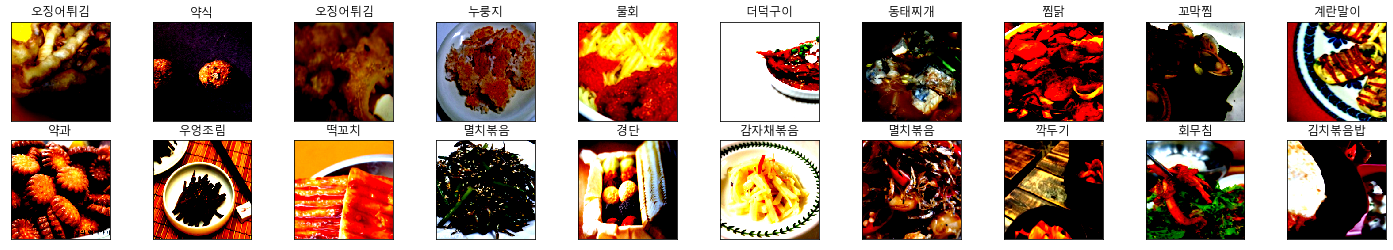

In [15]:
def im_convert(tensor):
    img = tensor.clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225] + np.array([0.485, 0.456, 0.406]))
    img = img.clip(0, 1)
    return img

class_names = os.listdir(data_dir)

dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
    # row 2 column 10
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(class_names[labels[i].item()])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = [] 
    val_acc_history = []
    
    path = './save/food_model_'
    print_iter = 10
    since = time.time()
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    num_batches = len(dataloaders['train'])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 50)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for iter_, data in enumerate(tqdm(dataloaders[phase])):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
#                         if (iter_ + 1) % print_iter == 0:
#                             _epoch = epoch + ((iter_ + 1) / num_batches)
#                             acc = preds.eq(labels).sum().item() / num_batches
#                             print('[{:.3f}/{:d}]  ( loss : {:.5f},  acc : {:.5f} ) '.format(_epoch, num_epochs, loss.item(), acc))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            #print('-' * 50)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                print('=' * 50)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                # model save
                torch.save(model.state_dict(), path + str(epoch))
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)  

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                        
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    history = [train_loss_history, train_acc_history, val_loss_history, val_acc_history]
    
    return model, best_acc, history

In [7]:
base_lr = 0.001

def init_weight(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            n = m.weight.size(1)
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

In [8]:
model_ft = models.resnet50(pretrained=None)
model_ft.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model_ft.fc = nn.Linear(512 * 4, 150)

num_epochs = 100
history = []
best_acc = 0

# PATH = './save/food_model_0'
# model_ft.load_state_dict(torch.load(PATH))
# model_ft.eval()

criterion  = nn.CrossEntropyLoss()
init_weight(model_ft)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model_ft = nn.DataParallel(model_ft)

model_ft = model_ft.to(device)
criterion = criterion.to(device)

optimizer_ft = Adam(
    [param for param in model_ft.parameters() if param.requires_grad],
    lr=base_lr, weight_decay=1e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=num_epochs, eta_min=0.)
#exp_lr_scheduler = StepLR(optimizer_ft, step_size=30, gamma=0.1)

Let's use 2 GPUs!


In [9]:
model_conv, best_acc, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/100
--------------------------------------------------


  0%|                                                                                         | 0/3763 [00:00<?, ?it/s]C:\Users\baek\Anaconda3\envs\pytorch\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:37<00:00,  4.40it/s]


train Loss: 4.2901 Acc: 0.0737


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:49<00:00,  5.57it/s]


val Loss: 3.8745 Acc: 0.1302

Epoch 2/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:44<00:00,  4.41it/s]


train Loss: 3.5536 Acc: 0.1766


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:52<00:00,  5.44it/s]


val Loss: 3.1371 Acc: 0.2484

Epoch 3/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:26<00:00,  4.44it/s]


train Loss: 3.0217 Acc: 0.2707


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:49<00:00,  5.57it/s]


val Loss: 2.7034 Acc: 0.3341

Epoch 4/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:37<00:00,  4.32it/s]


train Loss: 2.6681 Acc: 0.3409


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:49<00:00,  5.56it/s]


val Loss: 2.4590 Acc: 0.3880

Epoch 5/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:31<00:00,  4.51it/s]


train Loss: 2.4336 Acc: 0.3913


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.60it/s]


val Loss: 2.2351 Acc: 0.4295

Epoch 6/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:24<00:00,  4.35it/s]


train Loss: 2.2655 Acc: 0.4285


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:50<00:00,  5.51it/s]


val Loss: 2.1740 Acc: 0.4528

Epoch 7/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:25<00:00,  4.38it/s]


train Loss: 2.1489 Acc: 0.4560


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.57it/s]


val Loss: 2.0787 Acc: 0.4703

Epoch 8/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:32<00:00,  4.30it/s]


train Loss: 2.0620 Acc: 0.4751


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.58it/s]


val Loss: 2.0454 Acc: 0.4782

Epoch 9/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:37<00:00,  4.30it/s]


train Loss: 1.9813 Acc: 0.4935


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.44it/s]


val Loss: 2.1275 Acc: 0.4679

Epoch 10/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:36<00:00,  3.92it/s]


train Loss: 1.9264 Acc: 0.5058


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.43it/s]


val Loss: 1.8696 Acc: 0.5202

Epoch 11/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:45<00:00,  4.27it/s]


train Loss: 1.8752 Acc: 0.5168


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.24it/s]


val Loss: 1.7586 Acc: 0.5455

Epoch 12/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:52<00:00,  4.28it/s]


train Loss: 1.8309 Acc: 0.5281


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:51<00:00,  5.48it/s]


val Loss: 1.7618 Acc: 0.5479

Epoch 13/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:49<00:00,  4.34it/s]


train Loss: 1.7880 Acc: 0.5362


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.7060 Acc: 0.5611

Epoch 14/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:40<00:00,  4.20it/s]


train Loss: 1.7578 Acc: 0.5428


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:51<00:00,  5.47it/s]


val Loss: 1.7311 Acc: 0.5603

Epoch 15/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.45it/s]


train Loss: 1.7237 Acc: 0.5526


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:50<00:00,  5.51it/s]


val Loss: 1.6990 Acc: 0.5603

Epoch 16/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:03<00:00,  4.28it/s]


train Loss: 1.6930 Acc: 0.5589


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:02<00:00,  5.15it/s]


val Loss: 1.6373 Acc: 0.5826

Epoch 17/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:13<00:00,  4.37it/s]


train Loss: 1.6700 Acc: 0.5656


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:04<00:00,  5.09it/s]


val Loss: 1.7263 Acc: 0.5580

Epoch 18/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:07<00:00,  4.34it/s]


train Loss: 1.6439 Acc: 0.5717


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:57<00:00,  5.31it/s]


val Loss: 1.5822 Acc: 0.5902

Epoch 19/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:22<00:00,  4.33it/s]


train Loss: 1.6183 Acc: 0.5775


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:04<00:00,  5.11it/s]


val Loss: 1.5252 Acc: 0.6046

Epoch 20/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:57<00:00,  4.37it/s]


train Loss: 1.6003 Acc: 0.5812


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.5902 Acc: 0.5899

Epoch 21/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:07<00:00,  4.27it/s]


train Loss: 1.5842 Acc: 0.5871


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:03<00:00,  5.14it/s]


val Loss: 1.5405 Acc: 0.5969

Epoch 22/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:03<00:00,  4.37it/s]


train Loss: 1.5668 Acc: 0.5900


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:01<00:00,  5.20it/s]


val Loss: 1.6394 Acc: 0.5760

Epoch 23/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:20<00:00,  4.32it/s]


train Loss: 1.5509 Acc: 0.5928


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:03<00:00,  5.12it/s]


val Loss: 1.4759 Acc: 0.6193

Epoch 24/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:10<00:00,  4.20it/s]


train Loss: 1.5374 Acc: 0.5961


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:00<00:00,  5.20it/s]


val Loss: 1.5506 Acc: 0.5960

Epoch 25/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:10<00:00,  4.34it/s]


train Loss: 1.5152 Acc: 0.6025


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:03<00:00,  5.13it/s]


val Loss: 1.4945 Acc: 0.6071

Epoch 26/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:56<00:00,  4.36it/s]


train Loss: 1.5051 Acc: 0.6063


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.5018 Acc: 0.6114

Epoch 27/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.41it/s]


train Loss: 1.4915 Acc: 0.6094


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.4376 Acc: 0.6235

Epoch 28/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.29it/s]


train Loss: 1.4780 Acc: 0.6092


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.35it/s]


val Loss: 1.4106 Acc: 0.6316

Epoch 29/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.40it/s]


train Loss: 1.4673 Acc: 0.6150


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.4775 Acc: 0.6092

Epoch 30/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.34it/s]


train Loss: 1.4512 Acc: 0.6189


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.4364 Acc: 0.6279

Epoch 31/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.40it/s]


train Loss: 1.4442 Acc: 0.6211


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.3650 Acc: 0.6414

Epoch 32/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.41it/s]


train Loss: 1.4316 Acc: 0.6221


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.3788 Acc: 0.6350

Epoch 33/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.47it/s]


train Loss: 1.4219 Acc: 0.6244


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.4111 Acc: 0.6296

Epoch 34/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.31it/s]


train Loss: 1.4111 Acc: 0.6289


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.3910 Acc: 0.6335

Epoch 35/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.37it/s]


train Loss: 1.3985 Acc: 0.6295


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.3273 Acc: 0.6545

Epoch 36/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.32it/s]


train Loss: 1.3822 Acc: 0.6333


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.3509 Acc: 0.6488

Epoch 37/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.30it/s]


train Loss: 1.3778 Acc: 0.6366


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.43it/s]


val Loss: 1.2967 Acc: 0.6575

Epoch 38/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.30it/s]


train Loss: 1.3686 Acc: 0.6394


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.41it/s]


val Loss: 1.3268 Acc: 0.6522

Epoch 39/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.35it/s]


train Loss: 1.3586 Acc: 0.6409


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.3321 Acc: 0.6517

Epoch 40/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.38it/s]


train Loss: 1.3451 Acc: 0.6438


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.44it/s]


val Loss: 1.3116 Acc: 0.6551

Epoch 41/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.29it/s]


train Loss: 1.3254 Acc: 0.6489


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.3356 Acc: 0.6491

Epoch 42/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.39it/s]


train Loss: 1.3215 Acc: 0.6495


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.2538 Acc: 0.6698

Epoch 43/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.47it/s]


train Loss: 1.3150 Acc: 0.6528


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.41it/s]


val Loss: 1.3138 Acc: 0.6530

Epoch 44/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.37it/s]


train Loss: 1.2985 Acc: 0.6556


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.2798 Acc: 0.6636

Epoch 45/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.46it/s]


train Loss: 1.2936 Acc: 0.6573


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:57<00:00,  5.31it/s]


val Loss: 1.2562 Acc: 0.6722

Epoch 46/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.37it/s]


train Loss: 1.2749 Acc: 0.6622


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.38it/s]


val Loss: 1.2706 Acc: 0.6645

Epoch 47/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:45<00:00,  4.50it/s]


train Loss: 1.2688 Acc: 0.6631


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.2590 Acc: 0.6687

Epoch 48/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.49it/s]


train Loss: 1.2658 Acc: 0.6635


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.2235 Acc: 0.6768

Epoch 49/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:44<00:00,  4.48it/s]


train Loss: 1.2508 Acc: 0.6683


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.41it/s]


val Loss: 1.2164 Acc: 0.6769

Epoch 50/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.35it/s]


train Loss: 1.2354 Acc: 0.6707


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.36it/s]


val Loss: 1.1815 Acc: 0.6888

Epoch 51/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.31it/s]


train Loss: 1.2287 Acc: 0.6734


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.38it/s]


val Loss: 1.1806 Acc: 0.6863

Epoch 52/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.51it/s]


train Loss: 1.2120 Acc: 0.6767


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.1969 Acc: 0.6836

Epoch 53/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.41it/s]


train Loss: 1.1934 Acc: 0.6805


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.2258 Acc: 0.6760

Epoch 54/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.37it/s]


train Loss: 1.1928 Acc: 0.6825


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.39it/s]


val Loss: 1.1584 Acc: 0.6960

Epoch 55/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.33it/s]


train Loss: 1.1789 Acc: 0.6849


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.40it/s]


val Loss: 1.1652 Acc: 0.6906

Epoch 56/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:44<00:00,  4.36it/s]


train Loss: 1.1715 Acc: 0.6875


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.37it/s]


val Loss: 1.1803 Acc: 0.6885

Epoch 57/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:39<00:00,  4.34it/s]


train Loss: 1.1576 Acc: 0.6905


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.42it/s]


val Loss: 1.1571 Acc: 0.6934

Epoch 58/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:40<00:00,  4.44it/s]


train Loss: 1.1455 Acc: 0.6935


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:54<00:00,  5.38it/s]


val Loss: 1.1356 Acc: 0.7005

Epoch 59/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:45<00:00,  4.30it/s]


train Loss: 1.1415 Acc: 0.6955


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.35it/s]


val Loss: 1.1481 Acc: 0.6963

Epoch 60/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.41it/s]


train Loss: 1.1247 Acc: 0.6980


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.36it/s]


val Loss: 1.1169 Acc: 0.7033

Epoch 61/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.32it/s]


train Loss: 1.1153 Acc: 0.7013


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.36it/s]


val Loss: 1.0943 Acc: 0.7103

Epoch 62/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.44it/s]


train Loss: 1.1103 Acc: 0.7026


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.35it/s]


val Loss: 1.1162 Acc: 0.7053

Epoch 63/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.45it/s]


train Loss: 1.0972 Acc: 0.7058


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.34it/s]


val Loss: 1.0669 Acc: 0.7173

Epoch 64/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:37<00:00,  4.43it/s]


train Loss: 1.0890 Acc: 0.7078


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.33it/s]


val Loss: 1.0676 Acc: 0.7155

Epoch 65/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:41<00:00,  4.41it/s]


train Loss: 1.0755 Acc: 0.7111


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.37it/s]


val Loss: 1.0709 Acc: 0.7174

Epoch 66/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.43it/s]


train Loss: 1.0664 Acc: 0.7144


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.34it/s]


val Loss: 1.0729 Acc: 0.7169

Epoch 67/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.39it/s]


train Loss: 1.0564 Acc: 0.7176


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:57<00:00,  5.30it/s]


val Loss: 1.0326 Acc: 0.7271

Epoch 68/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.46it/s]


train Loss: 1.0419 Acc: 0.7191


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.37it/s]


val Loss: 1.0379 Acc: 0.7249

Epoch 69/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.13it/s]


train Loss: 1.0336 Acc: 0.7223


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:57<00:00,  5.32it/s]


val Loss: 1.0403 Acc: 0.7218

Epoch 70/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:44<00:00,  4.52it/s]


train Loss: 1.0242 Acc: 0.7253


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.32it/s]


val Loss: 1.0155 Acc: 0.7301

Epoch 71/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.42it/s]


train Loss: 1.0090 Acc: 0.7282


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.35it/s]


val Loss: 1.0017 Acc: 0.7337

Epoch 72/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:44<00:00,  4.43it/s]


train Loss: 1.0049 Acc: 0.7302


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.34it/s]


val Loss: 1.0234 Acc: 0.7301

Epoch 73/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.12it/s]


train Loss: 0.9919 Acc: 0.7335


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.36it/s]


val Loss: 0.9954 Acc: 0.7347

Epoch 74/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:39<00:00,  4.37it/s]


train Loss: 0.9846 Acc: 0.7351


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:55<00:00,  5.37it/s]


val Loss: 0.9883 Acc: 0.7367

Epoch 75/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:40<00:00,  4.37it/s]


train Loss: 0.9738 Acc: 0.7381


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.44it/s]


val Loss: 0.9784 Acc: 0.7401

Epoch 76/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:42<00:00,  4.26it/s]


train Loss: 0.9634 Acc: 0.7409


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:53<00:00,  5.44it/s]


val Loss: 0.9646 Acc: 0.7434

Epoch 77/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:04<00:00,  4.32it/s]


train Loss: 0.9490 Acc: 0.7434


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:04<00:00,  5.10it/s]


val Loss: 0.9707 Acc: 0.7419

Epoch 78/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:59<00:00,  4.47it/s]


train Loss: 0.9451 Acc: 0.7460


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:57<00:00,  5.31it/s]


val Loss: 0.9716 Acc: 0.7422

Epoch 79/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:17<00:00,  4.51it/s]


train Loss: 0.9373 Acc: 0.7463


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.24it/s]


val Loss: 0.9447 Acc: 0.7479

Epoch 80/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:47<00:00,  4.31it/s]


train Loss: 0.9251 Acc: 0.7511


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:52<00:00,  5.46it/s]


val Loss: 0.9533 Acc: 0.7461

Epoch 81/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:36<00:00,  4.44it/s]


train Loss: 0.9178 Acc: 0.7526


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.25it/s]


val Loss: 0.9522 Acc: 0.7450

Epoch 82/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:02<00:00,  4.45it/s]


train Loss: 0.9050 Acc: 0.7551


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:58<00:00,  5.28it/s]


val Loss: 0.9430 Acc: 0.7508

Epoch 83/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:01<00:00,  4.05it/s]


train Loss: 0.8988 Acc: 0.7573


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:01<00:00,  5.17it/s]


val Loss: 0.9196 Acc: 0.7553

Epoch 84/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:43<00:00,  4.28it/s]


train Loss: 0.8869 Acc: 0.7611


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.59it/s]


val Loss: 0.9338 Acc: 0.7514

Epoch 85/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:36<00:00,  4.21it/s]


train Loss: 0.8849 Acc: 0.7616


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.59it/s]


val Loss: 0.9263 Acc: 0.7552

Epoch 86/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:33<00:00,  4.31it/s]


train Loss: 0.8811 Acc: 0.7618


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.57it/s]


val Loss: 0.9130 Acc: 0.7543

Epoch 87/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:35<00:00,  4.36it/s]


train Loss: 0.8733 Acc: 0.7653


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:49<00:00,  5.54it/s]


val Loss: 0.9158 Acc: 0.7555

Epoch 88/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:26<00:00,  4.37it/s]


train Loss: 0.8712 Acc: 0.7647


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:49<00:00,  5.55it/s]


val Loss: 0.9036 Acc: 0.7597

Epoch 89/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:34<00:00,  4.40it/s]


train Loss: 0.8640 Acc: 0.7667


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.60it/s]


val Loss: 0.9038 Acc: 0.7593

Epoch 90/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:38<00:00,  4.32it/s]


train Loss: 0.8562 Acc: 0.7686


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.57it/s]


val Loss: 0.9010 Acc: 0.7597

Epoch 91/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:50<00:00,  4.28it/s]


train Loss: 0.8507 Acc: 0.7711


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:50<00:00,  5.51it/s]


val Loss: 0.8958 Acc: 0.7620

Epoch 92/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:33<00:00,  4.42it/s]


train Loss: 0.8463 Acc: 0.7705


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:50<00:00,  5.52it/s]


val Loss: 0.8961 Acc: 0.7622

Epoch 93/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:32<00:00,  4.51it/s]


train Loss: 0.8492 Acc: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:48<00:00,  5.59it/s]


val Loss: 0.8840 Acc: 0.7645

Epoch 94/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [14:37<00:00,  4.38it/s]


train Loss: 0.8433 Acc: 0.7734


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:56<00:00,  5.32it/s]


val Loss: 0.8826 Acc: 0.7658

Epoch 95/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:18<00:00,  4.13it/s]


train Loss: 0.8414 Acc: 0.7723


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:08<00:00,  5.00it/s]


val Loss: 0.8966 Acc: 0.7624

Epoch 96/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:18<00:00,  4.30it/s]


train Loss: 0.8385 Acc: 0.7735


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:00<00:00,  5.23it/s]


val Loss: 0.8894 Acc: 0.7629

Epoch 97/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:16<00:00,  4.36it/s]


train Loss: 0.8357 Acc: 0.7751


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:00<00:00,  5.21it/s]


val Loss: 0.8830 Acc: 0.7667

Epoch 98/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:19<00:00,  4.38it/s]


train Loss: 0.8417 Acc: 0.7733


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:59<00:00,  5.23it/s]


val Loss: 0.8932 Acc: 0.7621

Epoch 99/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:19<00:00,  4.34it/s]


train Loss: 0.8371 Acc: 0.7743


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:01<00:00,  5.18it/s]


val Loss: 0.8930 Acc: 0.7610

Epoch 100/100
--------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3763/3763 [15:20<00:00,  4.30it/s]


train Loss: 0.8358 Acc: 0.7747


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [03:02<00:00,  5.16it/s]


val Loss: 0.8858 Acc: 0.7647

Training complete in 1771m 21s
Best val Acc: 0.766701


In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            fig = plt.figure(figsize=(4, 25))
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('label : {}  /  predicted : {}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

<Figure size 432x288 with 0 Axes>

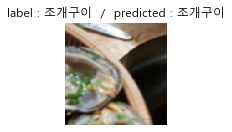

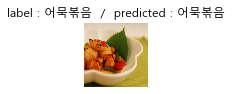

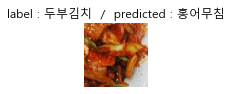

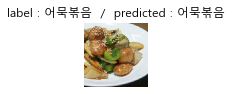

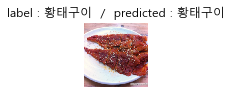

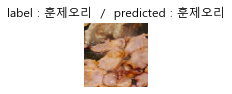

In [12]:
visualize_model(model_ft, num_images = 6)

plt.ioff()
plt.show()

In [23]:
def show_loss_plot(train_hist, val_hist, num_epochs=100):
    plt.plot(range(num_epochs), train_hist, 'b-', label='training loss')
    plt.plot(range(num_epochs), val_hist, 'r-', label='validation loss')
    plt.title('Loss_per_epochs')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='upper right', fontsize='large')
    plt.grid(linestyle='--', color='lavender')
    plt.show()

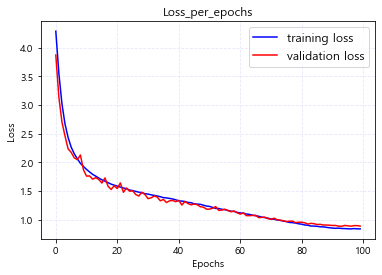

In [24]:
show_loss_plot(history[0], history[2])

In [25]:
def show_acc_plot(train_hist, val_hist, num_epochs=100):
    plt.plot(range(num_epochs), train_hist, 'b-', label='training accuracy')
    plt.plot(range(num_epochs), val_hist, 'r-', label='validation accuracy')
    plt.title('Accuracy_per_epochs')
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.ylim(0 , 1.0)
    plt.legend(loc='lower right', fontsize='large')
    plt.grid(linestyle='--', color='lavender')
    plt.show()

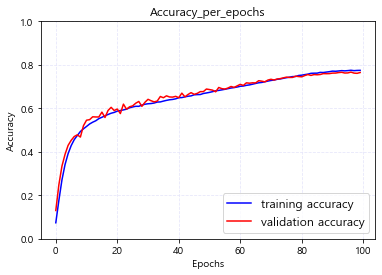

In [26]:
show_acc_plot(history[1], history[3])

In [ ]:
# # model_names = ['DPN92', 'PreActResNet18', 'DenseNet121', 'ResNeXt29', 'MobileNetV2', 'ResNet18', 'VGG16']
# model_names = ['MobileNet', 'VGG16C', 'VGG16D']
# model_architectures = []
# model_best_acc = []
# model_history = []

# mobileNet = models.model.mobileNet()
# VGG16C = models.model.VGG16C()
# VGG16D = models.model.VGG16D()

# model_architectures.append(mobileNet)
# model_architectures.append(VGG16C)
# model_architectures.append(VGG16D)

# # #DPN92 = models.dpn.DPN92()
# # PreActResNet18 = models.preact_resnet.PreActResNet18()
# # DenseNet121 = models.densenet.DenseNet121()
# # ResNeXt29 = models.resnext.ResNeXt29_2x64d()
# # MobileNetV2 = models.mobilenetv2.MobileNetV2()
# # ResNet18 = models.resnet.ResNet18()
# # VGG16 = models.vgg.VGG('VGG16')

# # #model_architectures.append(DPN92)
# # model_architectures.append(PreActResNet18)
# # model_architectures.append(DenseNet121)
# # model_architectures.append(ResNeXt29)
# # model_architectures.append(MobileNetV2)
# # model_architectures.append(ResNet18)
# # model_architectures.append(VGG16)

# for model in model_architectures:
#     history = []
#     best_acc = 0
    
#     criterion  = nn.CrossEntropyLoss()
#     init_weight(model)
    
#     if torch.cuda.device_count() > 1:
#         print("Let's use", torch.cuda.device_count(), "GPUs!")
#         # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#         model = nn.DataParallel(model)

#     model = model.to(device)
#     criterion = criterion.to(device)

#     optimizer_ft = Adam(
#         [param for param in model.parameters() if param.requires_grad],
#         lr=base_lr, weight_decay=1e-4)
    
#     exp_lr_scheduler = StepLR(optimizer_ft, step_size=40, gamma=0.1)

#     model_, best_acc, history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
    
#     model_best_acc.append(best_acc)
#     model_history.append(history)